## QML Estimation

$
y_t = \mu + \epsilon_t \\
\epsilon_t \sim \mathcal{N}(0, \sigma^2_{\epsilon} exp(h_t)) \\
h_{t+1} = \mu + \phi(h_{t} - \mu) + \xi_t \\
    \textrm{where } \xi_t \sim \mathcal{N}(0, \sigma^2_{\xi})
$

In [1]:
import numpy as np
import pandas as pd
import random as rd
import math
import matplotlib.pyplot as plt

##### i) Simulate the Model

In [2]:
from SV_Functions import sv_simul, sv_simul_v2

In [8]:
# Inputs
μ = 0
ϕ = 0.4
σ1 = 1
σ2 = 0.76
T = 500
h0 = 0

In [ ]:
data = sv_simul_v2(μ, ϕ, σ1, σ2, T, h0)
y = data[0]
h = data[1]
ϵ = data[2]

In [ ]:
plt.plot(range(T), r)

In [ ]:
plt.plot(range(T), h)

##### 2) Linearize the Model

$
ln(y_t^2) =  h_t + ln(\epsilon_t^2) = h_t + ln(\sigma_{\epsilon}^2) + ln(e_t^2), \textrm{ with } e_t \sim \mathcal{N}(0, 1) \\
c_t \approx ln(y_t^2) - ln(\sigma_{\epsilon}^2) + 1.2704 \\
d_t = \frac{1}{2} \pi^2
$

In [ ]:
log2_y = np.log(np.square(y))

In [ ]:
np.log(2)

### QML Estimation (Francq, Zakoian)

##### canonical SV Model

$
\epsilon_t = \sqrt{h_t} \eta_t \\
log(h_t) = \omega + \beta log(h_{t-1}) + \sigma v_t
$

$
\eta_t \sim \mathcal{N}(0,1) \\
v_t \sim \mathcal{N}(0,1)
$

##### State-space model

$
log (\epsilon_t^2) = log (h_t) + \mu_Z + u_t \\
log (h_t) = \beta log (h_{t-1}) + \omega + \sigma v_t
$

In [26]:
def sv_simul_can(ω, β, σ, log_h0):
    η = np.random.normal(0, 1, T)
    v  = np.random.normal(0, 1, T)
    ϵ = []
    log_h = []

    log_h.append(ω + β * log_h0 + σ * v[0])
    ϵ.append(np.sqrt(np.exp(log_h[0])) * η[0])

    for t in range(1, T):
        log_h.append(ω + β * log_h[t-1] + σ * v[t])
        ϵ.append(np.sqrt(np.exp(log_h[t])) * η[t])
        
    return ϵ, log_h

In [27]:
# Inputs
ω = 1e-3
β = 0.8
log_h0 = 0
σ = 0.76
T = 500

In [28]:
data = sv_simul_can(ω, β, σ, log_h0)
ϵ_t = data[0]
log_h_t = data[1]

In [33]:
def obj_sv(θ, ϵ_t):
    α_t = np.empty(0)
    P_t = np.empty(0)
    F_t = np.empty(0)
    K_t = np.empty(0)
    ω = θ[0]
    β = θ[1]
    σ = θ[2]
    μ_Z = -1.270
    σ_Z = np.pi**2 / 2
    a0 = 0.7
    P0 = 0
    T = len(ϵ_t)
    
    α_t = np.append(α_t, β * a0 + ω)
    P_t = np.append(P_t, β**2 * P0 + σ**2)
    K_t = np.append(K_t, 0)
    
    for t in range(1,T):
        F_t = np.append(F_t, P_t[t-1] + σ_Z**2)
        K_t = np.append(K_t, β * P_t[t-1] * 1/F_t[t-1])
        α_t = np.append(α_t, β * α_t[t-1] + K_t[t] * (ϵ_t[t-1] - α_t[t-1] - μ_Z) + ω)
        P_t = np.append(P_t, β**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + σ**2)
    F_t = np.append(F_t, P_t[T-1] + σ_Z**2)
    
    qml = T/2 * np.log(2*np.pi) - 1/2 * np.sum(np.square(np.log(F_t) + (np.log(np.square(ϵ_t)) - α_t - μ_Z)) / F_t)
    return qml

In [34]:
ω0 = 1e-3
β0 = 0.7
σ0 = 0.6
θ0 = [ω0, β0, σ0]
obj_sv(θ0, ϵ_t)

297.9827726171092

In [35]:
import scipy as sp

In [36]:
def estim_sv(ω0, β0, σ0, ϵ_t):
    valinit = [ω0, β0, σ0]
    res = minimize(obj_sv, valinit, args=(ϵ_t)) 
    est_param = res.x
    ω_hat = est_param[0]
    β_hat = est_param[1]
    σ_hat = est_param[2]
    likeli = res.fun
    return ω_hat, β_hat, σ_hat, likeli

In [37]:
estim_sv(ω0, β0, σ0, ϵ_t)

(-23566660.77250515,
 -157.36127520497496,
 -3568.2762555361883,
 -10406909734.646652)

### Estimate GARCH Models

In [3]:
def garch_simul(θ, T):
    η = np.random.normal(0, 1, T)
    ϵ_t = np.empty(0)
    σ2 = np.empty(0)
    ω = θ[0]
    α = θ[1]
    β = θ[2]
    
    ϵ_t = np.append(ϵ_t, np.sqrt(ω) * η[0])
    σ2 = np.append(σ2, ω)
    
    for t in range(1, T):
        σ2 = np.append(σ2, ω + α * ϵ_t[t-1]**2 + β * σ2[t-1])
        ϵ_t = np.append(ϵ_t, np.sqrt(σ2[t]) * η[t])
        
    return ϵ_t, σ2

In [4]:
def obj_garch(θ, ϵ_t):
    ω = θ[0]
    α = θ[1]
    β = θ[2]
    T = len(ϵ_t)
    σ2 = np.empty(0)
    
    σ2= np.append(σ2, ω)
    for t in range(1,T):
        σ2 = np.append(σ2, ω + α * ϵ_t[t-1]**2 + β * σ2[t-1])
    qml = np.mean(np.log(σ2[1:T]) + np.square(ϵ_t[1:T]) / σ2[1:T])
    return qml

In [5]:
def estim_garch(θ, ϵ_t):
    valinit = θ
    res = minimize(obj_garch, valinit, args=(ϵ_t), bounds=((1e-4, math.inf), (0, math.inf), (0, 0.999))) 
    θ_hat = res.x
    likeli = res.fun
    return θ_hat, likeli

In [6]:
ω = 1e-3
α = 0.05
β = 0.9
θ = ω, α, β

In [9]:
results = garch_simul(θ, T)
ϵ_t = results[0]
σ2 = results[1]

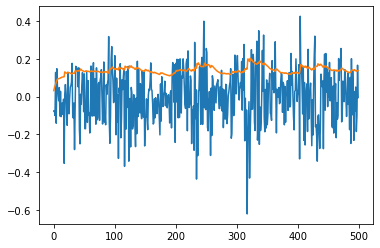

In [11]:
plt.plot(range(T), ϵ_t)
plt.plot(range(T), np.sqrt(σ2))

In [12]:
ω0 = 1e-3
α0 = 0.1
β0 = 0.8
θ0 = ω0, α0, β0

In [20]:
estimation = estim_garch(θ0, ϵ_t)
θ_hat = estimation[0]
θ_hat - θ

array([ 0.00065813,  0.04029309, -0.06813606])

In [ ]:
α

In [ ]:
sp.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None,
                        bounds=None, constraints=(), tol=None, callback=None, options=None)

In [ ]:
def square_fun(x):
    return x**2 + x + 2

In [16]:
from scipy.optimize import minimize

In [ ]:
x0 = 1
a = minimize(square_fun, 0, method='BFGS')

In [ ]:
def mini(paramt, a):
    x, y, z = paramt
    return x**2 + y**2 + z**2 + a

In [ ]:
first_guess = [0.5, 0.5, 0.5]

In [ ]:
res = minimize(mini, first_guess, args=(5))

In [ ]:
res

In [ ]:
import scipy

In [ ]:
# Estimation

# Inputs
ω_0 = 1e-3
β_0 = 0.7
σ_0 = 0.6

α_t = []
P_t = []
F_t = []

θ_0 = [ω_0, β_0, σ_0]

for t in range(T):
    log_like = -T/2 * np.log(2*np.pi) - 1/2 *
        np.sum(np.log(F_t[t] + (np.log(ϵ**2) - α_t[t]) - μ_Z)**2 / F_T[t])

